## Installation - Loading the Gymnasium custom environment: LifeSim

Since we're using a custom environment, we need to install its package into the pip environment, such that it will be usable from the gymnasium library. The following code is based on a Google Colab's run.

In [1]:
'''
# %%capture
#!rm -rf /content/gym_projects
!unzip - o / content/archive.zip
!pip uninstall - -no-input life-sim
!pip install - -no-input - e / content/gym_projects/
'''

'\n# %%capture\n#!rm -rf /content/gym_projects\n!unzip - o / content/archive.zip\n!pip uninstall - -no-input life-sim\n!pip install - -no-input - e / content/gym_projects/\n'

If the environment cannot be made with gymnasium.make(), it may be useful to restart the runtime.

In [2]:
'''
import os

def restart_runtime():
  os.kill(os.getpid(), 9)

restart_runtime()
'''


'\nimport os\n\ndef restart_runtime():\n  os.kill(os.getpid(), 9)\n\nrestart_runtime()\n'

## Creating the environment

In [3]:
import gymnasium as gym
import gymnasium.vector
import numpy as np
#import tensorflow as tf
#from tensorflow import keras
#from keras import initializers
from collections import deque
import random
from life_sim.envs import LifeSim, LifeSteps
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from agent import DQN_Agent, Agent, PPO_Agent
import agent
#from tensorflow import GradientTape
import memory
import tensorflow as tf
import importlib
importlib.reload(gym)
importlib.reload(memory)
importlib.reload(agent)

# Load the TensorBoard notebook extension
#%load_ext tensorboard
import datetime
log_dir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#summary_writer = tf.summary.create_file_writer(log_dir)
# Clear any logs from previous runs
#%rm -rf ./logs/

2023-06-28 22:32:03.347070: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-28 22:32:04.160527: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Set seeds for reproducibility.

In [4]:
seed = 9001
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [5]:

#tf.debugging.set_log_device_placement(True)
'''
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass
'''

"\nphysical_devices = tf.config.list_physical_devices('GPU')\ntry:\n  tf.config.experimental.set_memory_growth(physical_devices[0], True)\nexcept:\n  # Invalid device or cannot modify virtual devices once initialized.\n  pass\n"

Adding some useful settings and dictionaries to ease the code

In [6]:
# numpy settings for printing the states, if needed
np.set_printoptions(precision=8)

# some useful dictionaries used to let the code be more readable
# and less error-prone
num_actions = 3

actions = {
    "work": 0,
    "sport": 1,
    "sociality": 2
}

actions_array = {
    0: np.transpose([1, 0, 0]),
    1: np.transpose([0, 1, 0]),
    2: np.transpose([0, 0, 1]),
}

state_map = {
    "money": 0,
    "health": 1,
    "work development": 2,
    "social development": 3,
}

### Utils

Here we code some useful functions to visualize the results of the training and evaluate the model performance on the environment.

In [7]:
def plot_results(observations, rewards):
    # Plotting the first set of data
    performances = np.transpose(observations)
    plt.figure(1)
    plt.plot(performances[state_map['money']], label='Money')
    plt.plot(performances[state_map['health']], label='Health')
    plt.plot(performances[state_map['work development']],
             label='Work Development')
    plt.plot(performances[state_map['social development']],
             label='Social Development')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('State plot')
    plt.legend()

    # Plotting the second set of data
    plt.figure(2)
    plt.plot(rewards, label='Reward')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('Rewards plot')
    plt.legend()

    # Plotting the second set of data
    plt.figure(3)
    plt.plot(np.cumsum(rewards), label='Cumulative Reward')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('Cumulative reward plot')
    plt.legend()

    # Displaying the plots
    plt.show()


In [8]:
def training_results(rewards, actions, normalize=False):
    # Normalize the data
    actions = np.transpose(actions)

    if normalize:
        f = np.max(rewards)
        rewards = [r/f for r in rewards]
        f = np.max([np.max(actions[i]) for i in range(len(actions))])
        actions = [[a/f for a in actions[i]] for i in range(len(actions))]

    # Plotting the first set of data
    plt.figure(1)
    plt.plot(actions[0], label='Work')
    plt.plot(actions[1], label='Sport')
    plt.plot(actions[2], label='Sociality')
    plt.xlabel('Training Steps')
    plt.ylabel('Values')
    plt.xticks(np.arange(0, len(actions[0]), 1))
    plt.title('# of Actions, per training step')
    plt.legend()

    # Plotting the second set of data
    plt.figure(2)
    plt.plot(rewards, label='Cumulative Reward')
    plt.xlabel('Training Steps')
    plt.ylabel('Values')
    plt.xticks(np.arange(0, len(rewards), 1))
    plt.title('Cumulative Rewards plot, per training step')
    plt.legend()

    # Displaying the plots
    plt.show()


In [9]:
def plot_losses(actor_loss, critic_loss, logscale = False, reduce_n=None):

    if reduce_n is not None:
        actor_loss = np.array(actor_loss).reshape(-1, reduce_n).mean(axis=1)
        critic_loss = np.array(critic_loss).reshape(-1, reduce_n).mean(axis=1)

    plt.figure(1)
    plt.plot(actor_loss, label='Mean Actor Loss per Update')
    plt.xlabel('Updates')
    plt.xticks(np.arange(1,len(actor_loss),1))
    plt.ylabel('Mean loss')
    if logscale: plt.yscale('log')
    plt.title('Actor Loss Plot')
    plt.legend()

    plt.figure(2)
    plt.plot(critic_loss, label='Mean Critic Loss per Update')
    plt.xlabel('Updates')
    if logscale: plt.yscale('log')
    plt.xticks(np.arange(1,len(critic_loss),1))
    plt.ylabel('Mean loss')
    plt.title('Critic Loss Plot')
    plt.legend()

    # Displaying the plots
    plt.show()


### Training the Agent

In [10]:
def training_step(agent: Agent, batch_size):

    loss = agent.train(replay_buffer, batch_size)
    return loss


def add_cumulative_reward(cumulative_rewards, avg_sum_reward, sum_rewards, tau):

    avg_sum_reward = (avg_sum_reward*(tau - 1) + sum_rewards)/tau
    cumulative_rewards.append(avg_sum_reward)


def add_sum_action(sum_actions, avg_sum_actions, actions, tau):

    avg_sum_actions = (np.dot(avg_sum_actions, (tau - 1)) + actions)/tau
    sum_actions.append(avg_sum_actions)


def calc_epsilon(episode, n_episodes, decay):
    return max(1 - episode/(n_episodes*decay), 0.05)


In [11]:
def play_one_step(vec_env, v_actions, epsilon):

    next_states, rewards, terminateds, truncateds, infos = vec_env.step(v_actions)
    return next_states, rewards, terminateds, truncateds, infos, v_actions


In [12]:
def play_episodes(n_episodes, tau):
    # cumulative rewards averaged over tau episodes
    cumulative_rewards = []
    sum_actions = []

    avg_sum_reward = 0
    avg_sum_actions = np.transpose([0, 0, 0])

    for episode in tqdm(np.arange(1, n_episodes, 1), desc="Episodes", position=0):

        sum_rewards = 0
        actions = np.transpose([0, 0, 0])

        v_obs, v_info = vec_env.reset()

        for step in np.arange(1, max_steps, 1):

            epsilon = calc_epsilon(episode, n_episodes=n_episodes, decay=0.8)

            actions = [dqn_agent.predict(o, 0.5) for o in obs]

            v_new_obs, v_reward, v_terminated, v_truncated, v_info, v_action = play_one_step(
                vec_env, actions, epsilon)
            [replay_buffer.append((v_obs[i], v_action[i], v_reward[i],
                                  v_new_obs[i], v_terminated[i])) for i in range(len(obs))]

            sum_rewards = sum_rewards + np.sum(v_reward)
            actions = actions + actions_array[v_info['last_action']]

            []
            # env.render()
            # if terminated or truncated:
            #    break

        if episode % tau == 0:

            add_cumulative_reward(cumulative_rewards,
                                  avg_sum_reward, sum_rewards, tau)
            add_sum_action(sum_actions, avg_sum_actions, actions, tau)
        else:

            avg_sum_reward = (avg_sum_reward*(episode %
                              tau - 1) + sum_rewards)/(episode % tau)
            avg_sum_actions = (
                np.dot(avg_sum_actions, (episode % tau - 1)) + actions)/(episode % tau)

            if episode > 10 and episode % tau == 0:
                training_step(dqn_agent, batch_size)

    return cumulative_rewards, sum_actions


In [13]:
def play_steps(vec_env, max_steps, tau):
    # cumulative rewards averaged over tau episodes
    cumulative_rewards = []
    sum_actions = []

    avg_sum_reward = 0
    avg_sum_actions = np.transpose([0, 0, 0])

    steps = 0

    v_obs, v_info = vec_env.reset(seed=seeds)

    sum_rewards = 0
    actions = np.transpose([0, 0, 0])


    for steps in tqdm(np.arange(1, max_steps, 1), desc="Steps", position=0):

        epsilon = calc_epsilon(steps, max_steps, decay=0.8)
        v_actions = np.array([dqn_agent.predict(o, 0) for o in v_obs])
        #v_new_obs, v_reward, v_terminated, v_truncated, v_info, v_action = play_one_step(vec_env, v_actions, epsilon)
        v_new_obs, v_reward, v_terminated, v_truncated, v_info, v_action = play_one_step(vec_env, v_actions, epsilon)

        # save in buffer for the resetted envs
        # different code because of the vec_env.step() behaviour in case of truncated or terminated episode
        resetted_envs = [i for i in range(len(v_truncated)) if v_truncated[i] or v_terminated[i]]
        replay_buffer.extend([(v_obs[i], v_action[i], v_reward[i], v_info['final_observation'][i], v_terminated[i]) for i in resetted_envs])

        # save in buffer
        not_resetted_envs = [i for i in range(len(v_truncated)) if not v_truncated[i] and not v_terminated[i]]
        replay_buffer.extend([(v_obs[i], v_action[i], v_reward[i], v_new_obs[i], v_terminated[i]) for i in not_resetted_envs])

        #sum_rewards = sum_rewards + np.sum(v_reward)
        #actions = actions + \
        #    actions_array[np.sum(v_info['last_action'], axis=1)]

        if steps % tau == 0:
            training_step(dqn_agent, batch_size)

    
    return cumulative_rewards, sum_actions


In [14]:
'''
from tensorflow.compat import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
'''

'\nfrom tensorflow.compat import ConfigProto\nfrom tensorflow.compat.v1 import InteractiveSession\n\nconfig = ConfigProto()\nconfig.gpu_options.per_process_gpu_memory_fraction = 0.2\nconfig.gpu_options.allow_growth = True\nsession = InteractiveSession(config=config)\n'

In [15]:
# max number of steps for each episode of the simulator.
# if reached, the environment is TRUNCATED by the TimeLimit wrapper
#max_steps = 300
num_envs = 4

# seeds for evaluating
v_seeds = [int(x) for x in np.random.randint(1, 100000 + 1, size=1000)]

# seeds for testing
t_seeds = [int(x) for x in np.random.randint(1, 100000 + 1, size=1000)]

env_max_timesteps = 100
difficulty = 15

# create the vectorized environment
#vec_env = gymnasium.vector.make(
#    'life_sim/LifeSim-v0', num_envs=num_envs, asynchronous=True, max_timesteps=env_max_timesteps)
vec_env = gymnasium.vector.make(
    'life_steps/LifeSteps-v0', num_envs=num_envs, asynchronous=True, max_timesteps=env_max_timesteps, difficulty=difficulty, gamemode='standard')
#vec_env = gymnasium.vector.make(
#    'CartPole-v1', num_envs=num_envs, asynchronous=True)


In [16]:
from gymnasium.utils import env_checker
env = gymnasium.make('life_steps/LifeSteps-v0', max_timesteps=env_max_timesteps, difficulty=difficulty, gamemode='standard')
env_checker.check_env(env.unwrapped)
env.close()

| Life -> M: 29,   H: 32,   S: 32  -   F: alone.., I just started playing!
| Life -> M: 29,   H: 32,   S: 32  -   F: alone.., I just started playing!


In [17]:
env = gymnasium.make('life_steps/LifeSteps-v0', max_timesteps=env_max_timesteps, difficulty=difficulty, gamemode='monopoly')
env_checker.check_env(env.unwrapped)
env.close()

| Life -> M: 27,   H: 29,   S: 25  -   F: alone.., I just started playing!
| Life -> M: 27,   H: 29,   S: 25  -   F: alone.., I just started playing!


In [18]:
#input_shape = [5]
input_shape = [vec_env.single_observation_space.shape[0]]
n_outputs = vec_env.single_action_space.n
print(f'input shape: {input_shape}')
print(f'num output: {n_outputs}')

input shape: [4]
num output: 3


In [19]:
num_steps = 50000
# discount
gamma = 0.99
# lambda is the GAE parameter
lmbda = 0.95
# clipping parameter
epsilon = 0.2
# entropy parameter
c2 = 0.0
batch_timesteps = 128
minibatch_size = 32
epochs = 2

lr_actor = 2.5e-4
lr_critic = 2.5e-4

In [20]:
m = memory.Memory(num_envs = num_envs, obs_shape = (input_shape[0],), timesteps = batch_timesteps)

In [21]:
import agent
importlib.reload(agent)
ppo_agent = agent.PPO_Agent(input_shape, 
                            n_outputs, 
                            gamma, 
                            lmbda, 
                            epsilon, 
                            c2, 
                            lr_actor, 
                            lr_critic, 
                            log=True, 
                            log_dir=log_dir, 
                            env_max_timesteps=env_max_timesteps,
                            init_personal = True)

2023-06-28 22:32:06.651956: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-28 22:32:06.684816: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-28 22:32:06.685060: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Train the model for the decided time.

In [22]:
#from agent import play_n_timesteps
#mean_losses_actor, mean_losses_critic = ppo_agent.play_n_timesteps(vec_env, m, num_steps, batch_timesteps, minibatch_size, epochs)

# with tensorboard logging
ppo_agent.play_n_timesteps(vec_env, m, num_steps, batch_timesteps, minibatch_size, epochs, difficulty=difficulty, gamemode = 'standard')

  0%|          | 0/390 [00:00<?, ?it/s]

2023-06-28 22:32:09.767459: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f171802dd00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-28 22:32:09.767483: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce MX250, Compute Capability 6.1
2023-06-28 22:32:09.772306: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-28 22:32:09.945675: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-28 22:32:10.018680: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-28 22:32:10.076187: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
>>> Evaluation <<<
	Mean Cumulative Rewards: -101.000

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
>>> Evaluation <<<
	Mean Cumulative Rewards: -80.300

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
>>> Evaluation <<<
	Mean Cumulative Rewards: -61.400

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
>>> Evaluation <<<
	Mean Cumulative Rewards: -34.100

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
>>> Evaluation <<<
	Mean Cumulative Rewards: -28.400

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
>>> Evaluation <<<
	Mean Cumulative Rewards: 0.400

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
>>> Evaluation <<<
	Mean Cumulative Rewards: -18.900

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

Evaluating the model for 10 episodes.

In [33]:
eval_episodes = 10
eval_seeds = np.random.choice(t_seeds, size=eval_episodes).tolist()
print(eval_seeds)

# with tensorboard logging
render_mode = None
ppo_agent.evaluate(eval_episodes, seeds=eval_seeds, render_mode=render_mode, eval_code=90, difficulty = difficulty, gamemode='standard')

[12917, 59418, 33437, 2206, 61110, 49017, 12418, 15802, 85817, 481]
>>> Evaluation <<<
	Mean Cumulative Rewards: 1.000


1.0

A textual simulation.

In [24]:
eval_episodes = 1
ppo_agent.evaluate(eval_episodes, seeds=[eval_seeds[0]], render_mode='text', eval_code=90, difficulty = difficulty, gamemode = 'standard')

| Life -> M: 33,   H: 25,   S: 27  -   F: alone.., I just started playing!
| Life -> M: 28,   H: 32,   S: 26  -   F: alone..		|  Last Action: sport
| Life -> M: 33,   H: 29,   S: 25  -   F: alone..		|  Last Action: work
| Life -> M: 38,   H: 26,   S: 24  -   F: alone..		|  Last Action: work
| Life -> M: 43,   H: 23,   S: 23  -   F: alone..		|  Last Action: work
| Life -> M: 38,   H: 30,   S: 22  -   F: alone..		|  Last Action: sport
| Life -> M: 33,   H: 37,   S: 21  -   F: alone..		|  Last Action: sport
| Life -> M: 38,   H: 34,   S: 20  -   F: alone..		|  Last Action: work
| Life -> M: 43,   H: 31,   S: 19  -   F: alone..		|  Last Action: work
| Life -> M: 38,   H: 38,   S: 18  -   F: alone..		|  Last Action: sport
| Life -> M: 43,   H: 35,   S: 17  -   F: alone..		|  Last Action: work
| Life -> M: 38,   H: 32,   S: 26  -   F: alone..		|  Last Action: social
| Life -> M: 43,   H: 29,   S: 25  -   F: alone..		|  Last Action: work
| Life -> M: 38,   H: 36,   S: 24  -   F: alone..		|  L

1.0

Since we're happy with the results, let's save the actor and critic models, and close the vectorized environment.

In [25]:
vec_env.close()
#ppo_agent.save_models()

Now let's test the 'monopoly' gamemode.

In [36]:
eval_episodes = 10
#eval_seeds = np.random.choice(t_seeds, size=eval_episodes).tolist()
#env = gymnasium.make('life_sim/LifeSim-v0', render_mode='text', max_timesteps=env_max_timesteps)

print(eval_seeds)
# with tensorboard logging
ppo_agent.evaluate(eval_episodes, seeds=eval_seeds, render_mode=None, eval_code=110, difficulty = difficulty, gamemode='monopoly')

[33437, 12418, 85817, 59418, 2206, 49017, 15802, 12917, 61110, 481]
>>> Evaluation <<<
	Mean Cumulative Rewards: -30.800


-30.8

It's not working well, because it's much more difficult and the strategy to beat the game is different!

We need to fine-tune the network.

We'll create a new ppo_agent and reload the weights from the disk. In this way, if something goes wrong, we can try to change the parameters and do the fine tuning again.

In [27]:
num_steps = 20000
# discount
gamma = 0.99
# lambda is the GAE parameter
lmbda = 0.95
# clipping parameter
epsilon = 0.2
# entropy parameter
c2 = 0.0
batch_timesteps = 128
minibatch_size = 32
epochs = 2

lr_actor = 1e-4
lr_critic = 1e-4

ppo_agent_m = agent.PPO_Agent(input_shape, 
                            n_outputs, 
                            gamma, 
                            lmbda, 
                            epsilon, 
                            c2, 
                            lr_actor, 
                            lr_critic, 
                            log=True, 
                            log_dir=log_dir, 
                            env_max_timesteps=env_max_timesteps,
                            init_personal = True)

ppo_agent_m.load_models()
m.reset()

In [28]:
vec_env_m = gymnasium.vector.make(
    'life_steps/LifeSteps-v0', num_envs=num_envs, asynchronous=True, max_timesteps=env_max_timesteps, difficulty=difficulty, gamemode='monopoly')

In [29]:
ppo_agent_m.play_n_timesteps(vec_env_m, m, num_steps, batch_timesteps, minibatch_size, epochs, difficulty=difficulty, gamemode = 'monopoly')

  0%|          | 0/156 [00:00<?, ?it/s]

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
>>> Evaluation <<<
	Mean Cumulative Rewards: -54.600

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
>>> Evaluation <<<
	Mean Cumulative Rewards: -55.400

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
>>> Evaluation <<<
	Mean Cumulative Rewards: -53.300

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
>>> Evaluation <<<
	Mean Cumulative Rewards: -45.200

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
>>> Evaluation <<<
	Mean Cumulative Rewards: -41.400

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
>>> Evaluation <<<
	Mean Cumulative Rewards: -33.500

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
>>> Evaluation <<<
	Mean Cumulative Rewards: -37.000

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

In [37]:
ppo_agent.evaluate(eval_episodes,  seeds=eval_seeds, render_mode=None, eval_code=120, difficulty=difficulty, gamemode='monopoly')

>>> Evaluation <<<
	Mean Cumulative Rewards: -28.500


-28.5

A textual simulation.

In [39]:
ppo_agent.evaluate(1,  seeds=[eval_seeds[0]], render_mode='text', eval_code=13, difficulty=difficulty, gamemode='monopoly')

| Life -> M: 26,   H: 31,   S: 32  -   F: alone.., I just started playing!
| Life -> M: 21,   H: 38,   S: 31  -   F: alone..		|  Last Action: sport		| all ok -1 points loss
| Life -> M: 16,   H: 45,   S: 30  -   F: alone..		|  Last Action: sport		| all ok -1 points loss
| Life -> M: 21,   H: 42,   S: 29  -   F: alone..		|  Last Action: work		| all ok -1 points loss
| Life -> M: 26,   H: 39,   S: 28  -   F: alone..		|  Last Action: work		| all ok -1 points loss
| Life -> M: 31,   H: 36,   S: 27  -   F: alone..		|  Last Action: work		| all ok -1 points loss
| Life -> M: 36,   H: 23,   S: 26  -   F: alone..		|  Last Action: work		| ...got hurt while cooking... -10 points loss
| Life -> M: 31,   H: 30,   S: 25  -   F: alone..		|  Last Action: sport		| all ok -1 points loss
| Life -> M: 26,   H: 37,   S: 24  -   F: alone..		|  Last Action: sport		| all ok -1 points loss
| Life -> M: 31,   H: 34,   S: 23  -   F: alone..		|  Last Action: work		| all ok -1 points loss
| Life -> M: 36,   H: 31,

-67.0

Maybe we could try resetting some weights and see if the network can improve in a better way.

In [48]:
num_steps = 20000
# discount
gamma = 0.99
# lambda is the GAE parameter
lmbda = 0.95
# clipping parameter
epsilon = 0.2
# entropy parameter
c2 = 0.0
batch_timesteps = 128
minibatch_size = 32
epochs = 2

lr_actor = 1e-4
lr_critic = 1e-4

ppo_agent_m = agent.PPO_Agent(input_shape, 
                            n_outputs, 
                            gamma, 
                            lmbda, 
                            epsilon, 
                            c2, 
                            lr_actor, 
                            lr_critic, 
                            log=True, 
                            log_dir=log_dir, 
                            env_max_timesteps=env_max_timesteps,
                            init_personal = True)

ppo_agent_m.load_models()
m.reset()

In [54]:
for w_layer in ppo_agent_m.critic.weights:
    for w in w_layer:
        print(w)

tf.Tensor(
[ 0.3730084  -0.22811785 -0.2804292  -0.2752395   0.39336684  0.01459771
  0.16070448  0.13266458  0.2788061   0.36919716 -0.01663596  0.43816188
  0.03774277  0.15349025  0.23507051  0.13584217  0.18570043 -0.35653377
 -0.37102696 -0.05925484 -0.28031725  0.30753398  0.07588117 -0.1693393
  0.00550151 -0.28326294  0.28453085  0.05919597  0.10276093 -0.04930134
 -0.34227905  0.22630276], shape=(32,), dtype=float32)
tf.Tensor(
[-0.08514167  0.4735675  -0.16427118 -0.34009326 -0.16243272  0.32367095
 -0.38012052  0.10441102 -0.09203465  0.00346131 -0.27766418  0.00534929
  0.13124542  0.03756337  0.34585428  0.31463745 -0.15322815  0.04484527
 -0.12329045  0.1031074   0.03208692 -0.07288227  0.07714991  0.15184094
 -0.3708255   0.3817403  -0.00463886  0.11399254  0.5720277   0.29824707
 -0.27730528 -0.26046267], shape=(32,), dtype=float32)
tf.Tensor(
[-0.37375134  0.41744262  0.22081687 -0.28876615 -0.28171074 -0.10842222
 -0.5863863   0.27160028  0.3242934  -0.01211597  0.407

TODO

SHOULD TRAIN THE NETWORK AS NEW, WITHOUT USING THE WEIGHTS OF THE FIRST GAMEMODE.
Maybe it'll work.

Episodes:   0%|          | 0/10 [00:00<?, ?it/s]

| Life -> M: 26,   H: 29,   S: 26  -   F: alone.., I just started playing!
| Life -> M: 30,   H: 25,   S: 26  -   F: alone.., I just started playing!
| Life -> M: 34,   H: 25,   S: 27  -   F: alone.., I just started playing!
| Life -> M: 29,   H: 25,   S: 27  -   F: alone.., I just started playing!
| Life -> M: 28,   H: 26,   S: 25  -   F: alone.., I just started playing!
| Life -> M: 31,   H: 34,   S: 34  -   F: alone.., I just started playing!
| Life -> M: 29,   H: 27,   S: 25  -   F: alone.., I just started playing!
| Life -> M: 34,   H: 32,   S: 33  -   F: alone.., I just started playing!
| Life -> M: 31,   H: 32,   S: 25  -   F: alone.., I just started playing!
| Life -> M: 29,   H: 32,   S: 28  -   F: alone.., I just started playing!


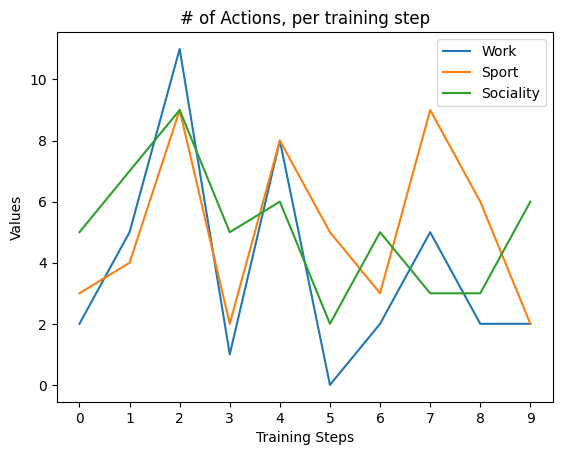

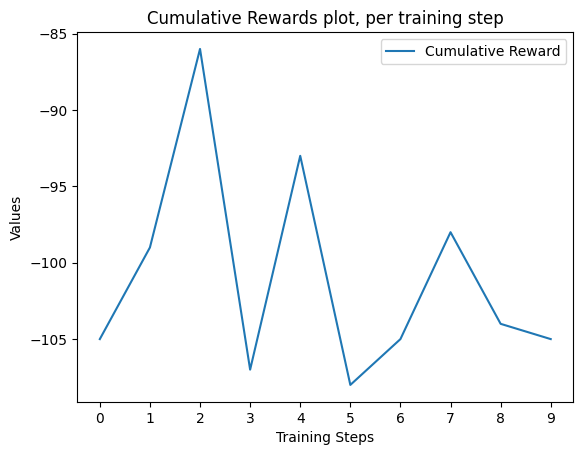

In [46]:
# max number of steps for each episode of the simulator.
# if reached, the environment is TRUNCATED by the TimeLimit wrapper
#max_steps = 300

# create the vectorized environment

env = gymnasium.make('life_steps/LifeSteps-v0', render_mode='text', max_timesteps=env_max_timesteps, difficulty=difficulty, gamemode='standard')

cumulative_rewards = []
sum_actions = []

avg_sum_reward = 0
avg_sum_actions = np.transpose([0, 0, 0])

n_episodes = 10

for episode in tqdm(np.arange(1, n_episodes+1, 1), desc="Episodes", position=0):

    #print(f"Episode {episode}")
    sum_rewards = 0
    actions = np.transpose([0, 0, 0])

    obs, info = env.reset()

    #for step in np.arange(1, max_steps, 1):
    while True:    
        epsilon = calc_epsilon(episode, n_episodes=n_episodes, decay=0.8)

        action = np.random.randint(3)

        new_obs, reward, terminated, truncated, info = env.step(action)

        actions = actions + actions_array[action]

        sum_rewards += reward
#        actions = actions + actions_array[v_info['last_action']]

        #env.render()
        if terminated or truncated:
           break

    sum_actions.append(actions)
    cumulative_rewards.append(sum_rewards)
    
training_results(cumulative_rewards, sum_actions)


Let's print the mean of the cumulative rewards obtained in the previous 50 evaluated episodes, taking random actions:

In [47]:
print(np.mean(cumulative_rewards))

-101.0


Let's keep training, because the performance are pretty awful.

In [ ]:
num_steps = 200000
# discount
gamma = 0.75
# lambda is the GAE parameter
lmbda = 0.95
# clipping parameter
epsilon = 0.1
# entropy parameter
c2 = 0.05
batch_timesteps = 128
minibatch_size = 32
epochs = batch_timesteps // minibatch_size

lr_actor = 1e-3
lr_critic = 6e-3

ppo_agent.actor.load_weights('actor_network_weights')
ppo_agent.critic.load_weights('critic_network_weights')

In [ ]:
mean_losses_actor, mean_losses_critic = ppo_agent.play_n_timesteps(vec_env, m, num_steps, batch_timesteps, minibatch_size, epochs)

ppo_agent.actor.save_weights('checkpoints/actor/actor_network_weights_2')
ppo_agent.critic.save_weights('checkpoints/critic/critic_network_weights_2')

plot_losses(mean_losses_actor, mean_losses_critic, logscale = False, reduce_n=None)

  0%|          | 0/1562 [00:00<?, ?it/s]

2023-06-18 10:45:13.302969: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at sparse_xent_op.cc:102 : INVALID_ARGUMENT: Received a label value of 3 which is outside the valid range of [0, 3).  Label values: 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3


InvalidArgumentError: {{function_node __wrapped__SparseSoftmaxCrossEntropyWithLogits_device_/job:localhost/replica:0/task:0/device:CPU:0}} Received a label value of 3 which is outside the valid range of [0, 3).  Label values: 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 [Op:SparseSoftmaxCrossEntropyWithLogits]

Here we should start training and testing the DQN

In [ ]:
tau = 100
max_steps = 1585

cumulative_rewards, sum_actions = play_steps(vec_env, max_steps, tau)
training_results(cumulative_rewards, sum_actions, normalize=True)

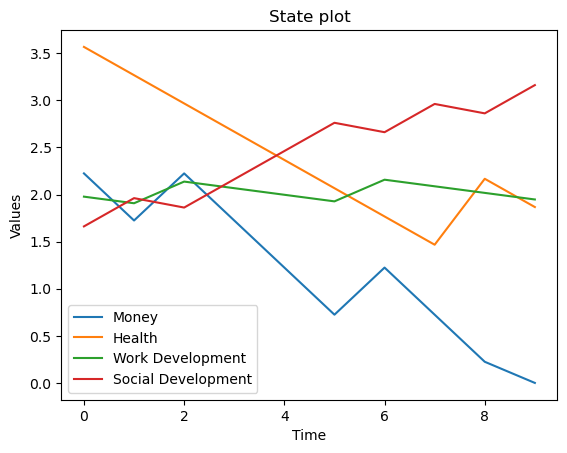

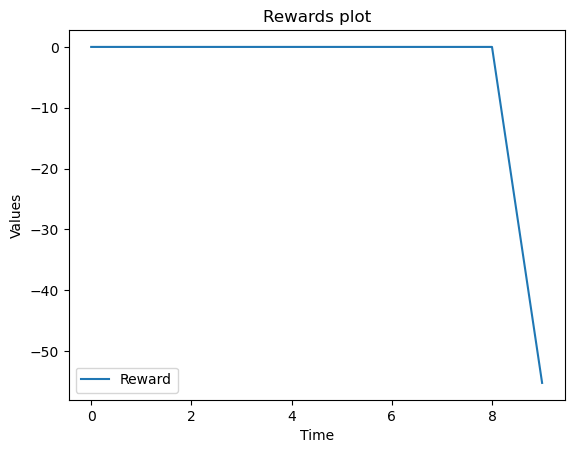

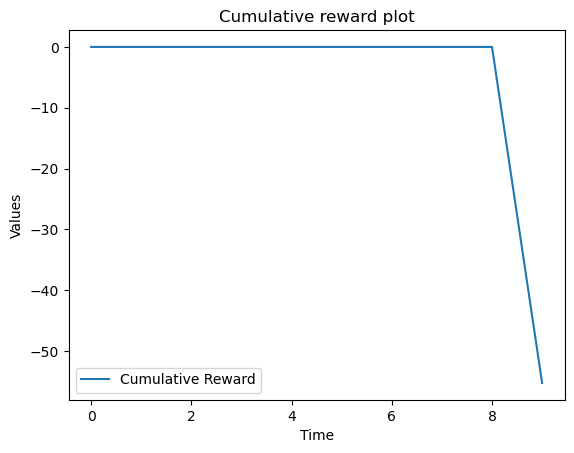

In [ ]:
observations = []
rewards = []

obs, info = env.reset()

done = False
terminated = False
while not done and not terminated:
    obs, reward, terminated, truncated, info = env.step(np.random.randint(3))
    # print(np.array2string(obs))
    observations.append(obs)
    # print(np.array2string(reward))
    rewards.append(reward)
    if terminated or truncated:
        break

plot_results(observations, rewards)


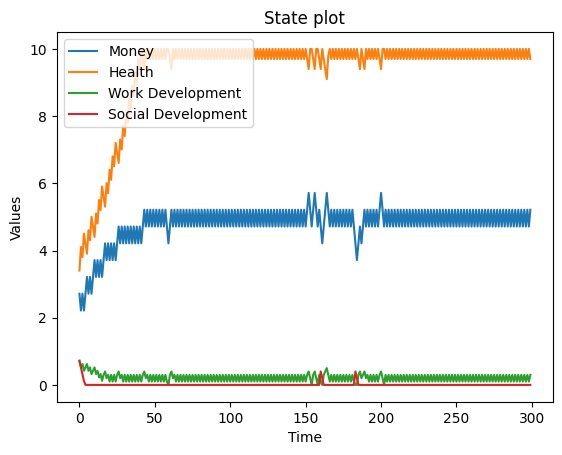

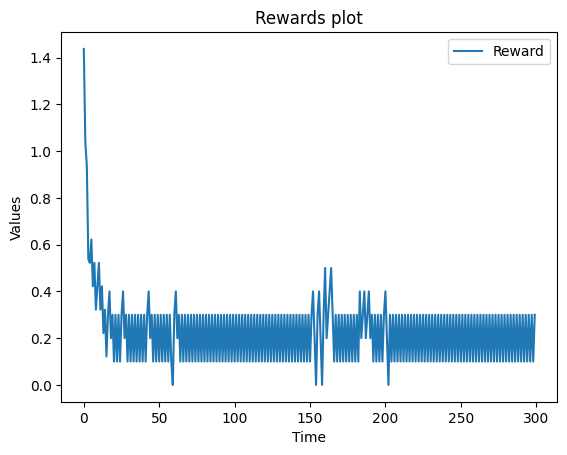

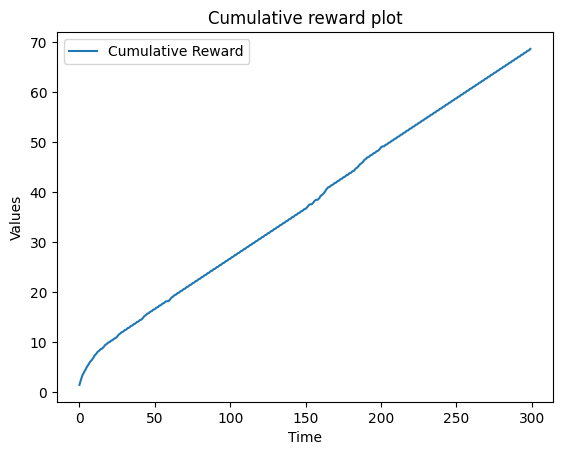

In [ ]:
observations = []
rewards = []

for episode in range(1):

    obs, info = env.reset()
    for step in range(1000):
        epsilon = 0.05
        obs, reward, terminated, truncated, info, action = dqn_agent.play_one_step(
            env, obs, epsilon)
        observations.append(obs)
        rewards.append(reward)
        # env.render()
        if terminated or truncated:
            break

plot_results(observations, rewards)
